# Scatter plot

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [89]:
import geopandas as gpd
import ocha_stratus as stratus
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import xarray as xr
from tqdm.auto import tqdm
from dask.diagnostics import ProgressBar

from src.constants import *
from src.datasources import codab, imerg

## Load data

### CODAB

In [70]:
adm0 = codab.load_codab_from_blob()

## Historical stats

Calculated in `ibtracs_imerg_agg.ipynb` then merged with EM-DAT in `emdat.ipynb`

In [50]:
blob_name = f"{PROJECT_PREFIX}/processed/ibtracs_imerg_emdat_stats.parquet"
df_stats_raw = stratus.load_parquet_from_blob(blob_name)

In [51]:
df_stats["Total Affected"] = df_stats["Total Affected"].fillna(0)
df_stats = df_stats[df_stats["season"] < 2025]

## Check correlations

<Axes: >

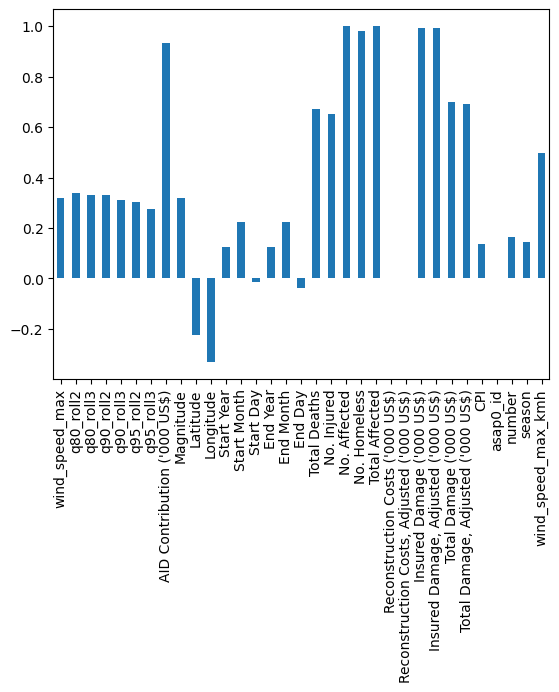

In [52]:
df_stats.corr(numeric_only=True)["Total Affected"].plot.bar()

In [60]:
df_stats_with_impact = df_stats[df_stats["Total Affected"] > 0]

<Axes: >

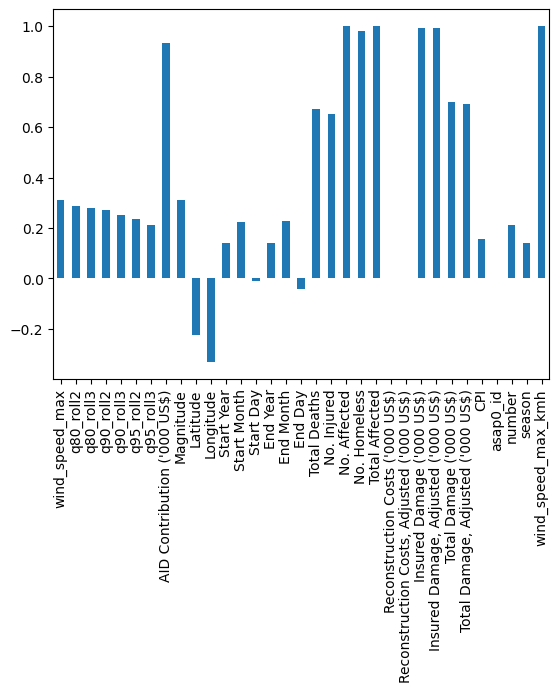

In [87]:
df_stats_with_impact.corr(numeric_only=True)["Total Affected"].plot.bar()

Seems like `q80_roll2` is best for rainfall. We can just check that by running a regression with wind and swapping in the various rainfall columns to see which performs best.

In [61]:
target = "Total Affected"  # your single target column
fixed_col = "wind_speed_max"  # the one you definitely want
other_cols = [
    x for x in df_stats.columns if "roll" in x
]  # the ones you want to test

results = []

for other in other_cols:
    X = df_stats[[fixed_col, other]]
    X = sm.add_constant(X)  # adds intercept term
    y = df_stats[target]

    model = sm.OLS(y, X).fit()
    r2 = model.rsquared

    results.append(
        {
            "other_col": other,
            "r2": r2,
        }
    )

results_df = pd.DataFrame(results).sort_values("r2", ascending=False)
print(results_df)

   other_col        r2
0  q80_roll2  0.208487
1  q80_roll3  0.205793
2  q90_roll2  0.196682
3  q90_roll3  0.187713
4  q95_roll2  0.181907
5  q95_roll3  0.169990


Yeah seems like `q80_roll2` is best but honestly none of these $R^{2}$ values are very good.

## Load IMERG

In [68]:
# get IMERG
query = """
SELECT *
FROM public.imerg
WHERE pcode = 'PH'
"""
with stratus.get_engine(stage="prod").connect() as con:
    df_imerg = pd.read_sql(query, con)

Check to see the most recent dates we have.

In [71]:
df_imerg.sort_values("valid_date").iloc[-10:]

,iso3,pcode,valid_date,adm_level,mean,median,min,max,count,sum,std
9284,PHL,PH,2025-10-30,0,9.871930,6.380000,0.0,145.160020,9690,95659.000,11.348069
9088,PHL,PH,2025-10-31,0,2.113457,0.660000,0.0,42.840000,9690,20479.395,3.678227
9285,PHL,PH,2025-11-01,0,9.248251,3.252500,0.0,117.454994,9690,89615.555,16.472317
9089,PHL,PH,2025-11-02,0,8.686870,4.425000,0.0,102.710010,9690,84175.766,11.554916
9090,PHL,PH,2025-11-03,0,44.661694,31.015003,0.0,222.105010,9690,432771.780,45.000313
9286,PHL,PH,2025-11-04,0,29.925407,17.329998,0.0,252.264980,9690,289977.220,35.095192
9287,PHL,PH,2025-11-05,0,4.915937,1.360000,0.0,72.454994,9690,47635.430,8.187761
9091,PHL,PH,2025-11-06,0,3.442266,0.992500,0.0,69.105000,9690,33355.555,5.666709
9092,PHL,PH,2025-11-07,0,2.432125,1.415000,0.0,26.154999,9690,23567.295,3.137913
9093,PHL,PH,2025-11-08,0,22.027640,8.485001,0.0,223.105010,9690,213447.810,32.049828


### Get recent IMERG rasters

In [127]:
# grabbing for the most recent dates that seem to be from Fung-Wong
# the max date can be updated once we get more rainfall data
imerg_dates = pd.date_range("2025-11-08", "2025-11-08")

In [77]:
da_imerg_raw = imerg.open_imerg_raster_dates(imerg_dates)

In [78]:
da_imerg = da_imerg_raw.rio.clip(adm0.geometry)

In [79]:
da_imerg_roll2 = da_imerg.rolling(date=2, min_periods=1).sum()

In [81]:
da_imerg_roll2_q = da_imerg_roll2.quantile(0.8, dim=["x", "y"])

## Get Fung-Wong current values

In [83]:
fungwong_imerg = float(da_imerg_roll2_q.max())

In [84]:
fungwong_imerg

33.20999832153321

In [88]:
# from https://agora.ex.nii.ac.jp/digital-typhoon/summary/wnp/l/202526.html.en
fungwong_wind = 85

## Plot

In [125]:
def plot_stats(
    wind_col="wind_speed_max",
    rain_col="q80_roll2",
    impact_col="Total Affected",
):
    df_plot = df_stats_with_impact.copy()
    # cerf_color = "crimson"
    fig, ax = plt.subplots(figsize=(7, 7), dpi=200)

    ymax = df_plot[rain_col].max() * 1.1
    xmax = df_plot[wind_col].max() * 1.1

    bubble_sizes = df_plot[impact_col].fillna(0)
    bubble_sizes_scaled = bubble_sizes / bubble_sizes.max() * 2000

    ax.scatter(
        df_plot[wind_col],
        df_plot[rain_col],
        s=bubble_sizes_scaled,
        # c=df_stats["cerf"].apply(lambda x: cerf_color if x else "k"),
        alpha=0.3,
        edgecolor="none",
        zorder=1,
    )

    for _, row in df_plot.iterrows():
        ax.annotate(
            row["name"].capitalize() + "\n" + str(row["season"]),
            (row[wind_col], row[rain_col]),
            ha="center",
            va="center",
            fontsize=4,
            # color=cerf_color if row["cerf"] == True else "k",
            # zorder=10 if row["cerf"] else 9,
            alpha=0.8,
        )

    ax.scatter(
        [fungwong_wind],
        [fungwong_imerg],
        marker="x",
        color=CHD_GREEN,
        linewidths=3,
        s=100,
    )
    ax.annotate(
        f"Fung-Wong\nlandfall wind speed\nand rainfall up to {imerg_dates.max().date()}",
        xy=(fungwong_wind, fungwong_imerg),  # point to highlight
        xytext=(
            90,
            300,
        ),  # position of the label
        va="center",
        ha="center",
        color=CHD_GREEN,
        fontweight="normal",
        fontsize=8,
        arrowprops=dict(
            arrowstyle="-",  # simple line, no arrowhead
            color=CHD_GREEN,  # same color as text
            lw=0.5,  # fine line
            alpha=0.8,
        ),
    )

    legend_text = (
        "    Size of bubble proportional to\n"
        "    total number of people affected [EM-DAT]"
    )
    ax.annotate(
        legend_text,
        (0, 390),
        va="top",
        fontsize=6,
        fontstyle="italic",
        color="grey",
    )

    ylabel = (
        "Two-day rainfall, 80th percentile over whole country (mm) [IMERG]"
        if rain_col == "q80_roll2"
        else rain_col
    )
    ax.set_ylabel(ylabel)
    ax.set_xlabel(
        "Max. wind speed while within 230 km of Philippines (knots) [IBTrACS]"
    )

    ax.set_xlim(left=0, right=xmax)
    ax.set_ylim(bottom=0, top=ymax)

    ax.set_title("Philippines: historical rainfall and wind speed")

    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    return fig, ax

(<Figure size 1400x1400 with 1 Axes>,
 <Axes: title={'center': 'Philippines: historical rainfall and wind speed'}, xlabel='Max. wind speed while within 230 km of Philippines (knots) [IBTrACS]', ylabel='Two-day rainfall, 80th percentile over whole country (mm) [IMERG]'>)

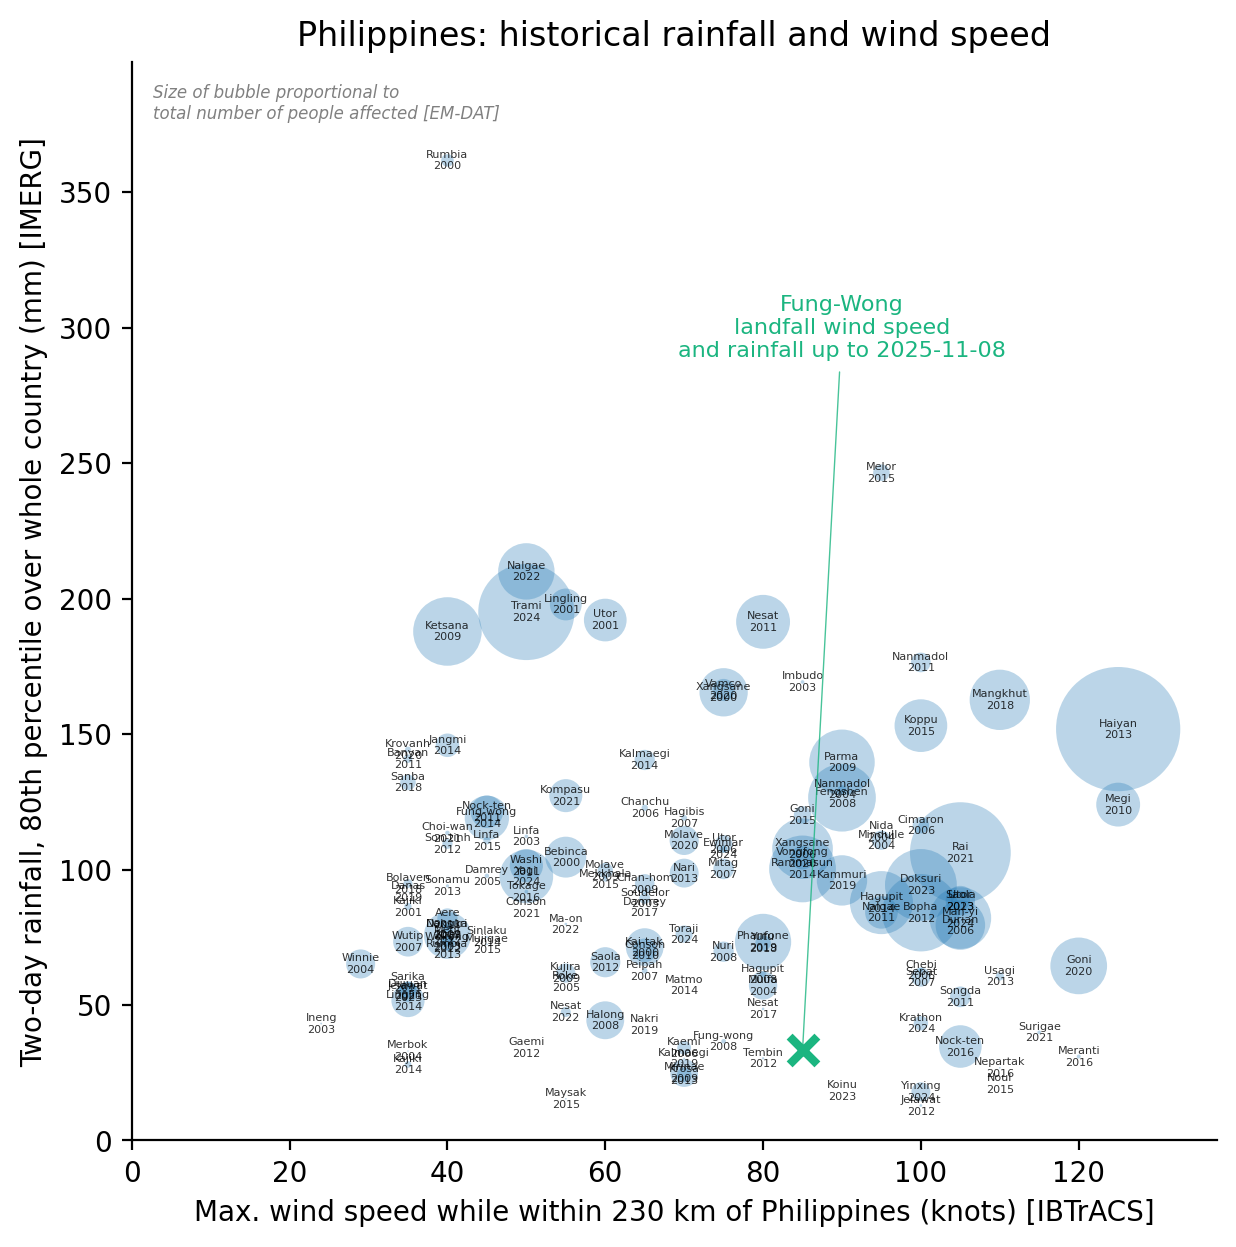

In [126]:
plot_stats()